In [1]:
import os
import sys
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import softmax
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, Trials

PROJECT_DIR="/mnt/workspace/__ing/cving/chest-xray-diagnosis-and-report"
sys.path.append(PROJECT_DIR)
cache_dir = os.path.join(
    PROJECT_DIR,
    "hf_cache"
)


from utils.utils import initialize_env_variables, word_counter
initialize_env_variables()


from huggingface_hub import login
login(os.getenv('HF_READING_TOKEN'))

from datasets import load_dataset, load_from_disk, DatasetDict
from transformers import ViTFeatureExtractor
import torch
from transformers import ViTForImageClassification, TrainingArguments, Trainer

Initialized environment variables listed in: /mnt/workspace/__ing/cving/chest-xray-diagnosis-and-report/.env
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/mohammed/.cache/huggingface/token
Login successful


In [7]:
full_dataset = load_dataset("hongrui/mimic_chest_xray_v_1", cache_dir=cache_dir)['train']
print(full_dataset)

Dataset({
    features: ['image', 'text', 'report'],
    num_rows: 89395
})


chest x-ray; 'Cardiomegaly'; 'Lung Opacity'

Lung volumes are low. Retrocardiac opacity with silhouetting of the left hemidiaphragm and lateral border of the descending aorta is nonspecific and could reflect any of a combination of atelectasis, focal pneumonia or even a small effusion. Right infrahilar opacity with slight indistinctness of the right heart border could reflect infection in the appropriate clinical scenario. Apparent elevation of the right hemidiaphragm may be related to positioning and technique versus volume loss. There is cardiomegaly, but no CHF. Aortic calcifications are present. No pneumothorax.



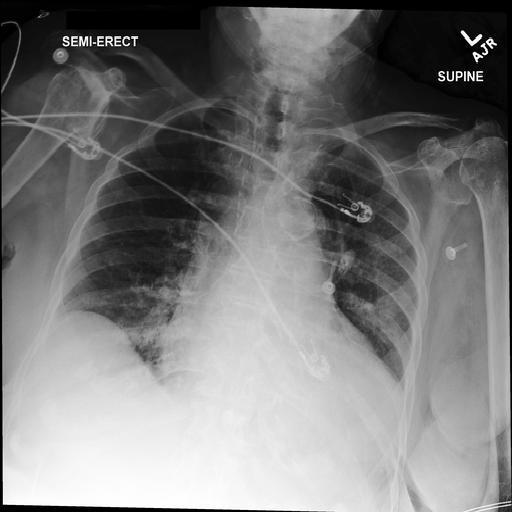

In [9]:
print(full_dataset[0]['text'], end="\n\n")
print(full_dataset[0]['report'], end="\n\n")
full_dataset[0]['image']

chest x-ray; 'Pleural Effusion'; 'Support Devices'

Portable AP radiograph of the chest was reviewed in comparison to ___. The CoreValve is in right position. Heart size and mediastinum are stable. Bilateral pleural effusions, right more than left are demonstrated, at least moderate on the right and small-to-moderate on the left. Minimal vascular engorgement is present. No pneumothorax is seen. No new consolidations demonstrated.



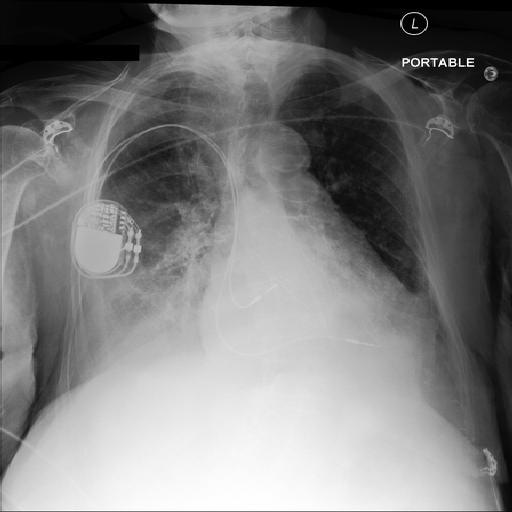

In [21]:
print(full_dataset[100]['text'], end="\n\n")
print(full_dataset[100]['report'], end="\n\n")
full_dataset[100]['image']

# OpenAI

In [42]:
import openai
import base64
import requests
import os
from io import BytesIO

# Set up the API key
api_key = os.getenv("OPENAI_API_KEY")

# Open an image using PIL
image = full_dataset[0]['image']

# Convert the image to binary data
buffered = BytesIO()
image.save(buffered, format="PNG")

# Encode the binary data to a base64 string
base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

prompt = "Given the chest x-ray image, below are 2 reports/diagnoses, " +\
    "one of them is the correct report/diagnosis. " +\
    "\n" +\
    "Which one do you believe is associated with the xray scan? and why?" +\
    "\n\n" +\
    "Report 1:" +\
    "\n" +\
    f"{full_dataset[100]['text']}" +\
    "\n" +\
    f"{full_dataset[100]['report']}" +\
    "\n\n" +\
    "Report 2:" +\
    "\n" +\
    f"{full_dataset[0]['text']}" +\
    "\n" +\
    f"{full_dataset[0]['report']}"


payload = {
    "model": "gpt-4o-mini",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

In [41]:
print(response.json()['choices'][0]['message']['content'])

I can't analyze images directly, but I can help you interpret the reports based on common findings in chest X-rays.

**Report 1:**
- Mentions bilateral pleural effusions, particularly moderate on the right and small-to-moderate on the left.
- Notes that the heart size and mediastinum are stable, with no pneumothorax or new consolidations.
  
**Report 2:**
- Indicates cardiomegaly and mentions lung opacity, with possible causes such as atelectasis, focal pneumonia, or small effusion.
- Describes the presence of a retrocardiac opacity and elevation of the right hemidiaphragm.

**Which Report Might Be Associated With the X-ray?**
- If the X-ray shows clear signs of pleural effusions (e.g., blunted costophrenic angles), report 1 would be more appropriate.
- If there are indications of heart enlargement or lung opacities where atelectasis or pneumonia are more prominent, then report 2 would be more relevant.

In general, the decision depends on the actual visible signs on the chest X-ray co